<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import misc
from scipy.optimize import curve_fit
from scipy import stats

Returns the poisson distribution

$$P_m(x) = \frac{m^x e^{-m}}{x!} $$

In [3]:
def poisson(x, mean):
    return np.exp(-mean)*(mean**x)/sp.special.factorial(x)

Returns the Gaussian distribution

In [4]:
def norm(x, u, sig, amp):
    return amp*np.exp(-((x-u)**2)/(2*sig**2))

Computes the chi squared distribution for different values of $m$ above.

In [5]:
def compute_chi2(m, count_act, freq_act, num_events):
    
    tot = 0
    for count, freq in zip(count_act, freq_act):
        theo = num_events*poisson(count, m) 
        tot += ((freq-theo)**2)/(theo)
        
    return tot

Compute Chi2 for the Gaussian

In [6]:
def compute_chi2_gaus(freq_act, freq_gaus):
    
    tot = 0
    for act, gaus in zip(freq_act, freq_gaus): 
        tot += ((act-gaus)**2)/(gaus)
        
    return tot

# Setting Up the Input Voltage

In [7]:
volt_top = np.array([1.2, 1.246, 1.303, 1.352, 1.402, 1.421, 1.440, 1.460, 1.482, 1.500, 
           1.520, 1.540, 1.562, 1.579, 1.599, 1.652, 1.701, 1.429])
counts_top = np.array([225, 367, 632, 722, 837, 935, 941, 1097, 1293, 1363, 1515, 1646, 1724,
             1936, 2131, 2497, 2798, 949])

volt_bot = np.array([1.196, 1.244, 1.267, 1.298, 1.326, 1.359, 1.393, 1.438, 1.216, 1.231, 
                     1.156, 1.102])
counts_bot = np.array([787, 1032, 1143, 1448, 1615, 1982, 2096, 2570, 882, 931, 699, 443])


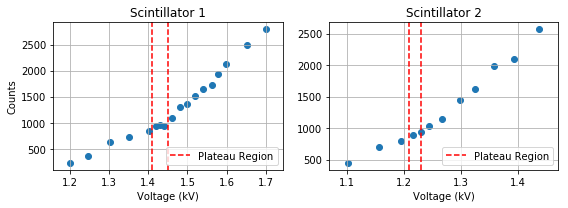

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))

axes[0].scatter(volt_top, counts_top)
axes[0].set_xlabel('Voltage (kV)')
axes[0].set_ylabel('Counts')
axes[0].set_title('Scintillator 1')

axes[1].scatter(volt_bot, counts_bot)
axes[1].set_xlabel('Voltage (kV)')
axes[1].set_title('Scintillator 2')

axes[0].axvline(1.41, color='r', linestyle='--', label='Plateau Region')
axes[0].axvline(1.45, color='r', linestyle='--')
axes[0].legend()

axes[1].axvline(1.21, color='r', linestyle='--', label='Plateau Region')
axes[1].axvline(1.23, color='r', linestyle='--')
axes[1].legend()

axes[0].grid()
axes[1].grid()


fig.tight_layout()
plt.savefig("plots/plateau.png", bbox_inches='tight', dpi=600)
plt.show()

# Counting Data

## 3 Count Interval Bottom Scintillator 1.23V

Open data:

In [9]:
df = pd.read_csv('plateau_data/solo_3.txt', skiprows=12, names=['counts'])
data = df['counts'][0:315].astype(int)
num_events = len(data)

Get Distributions:

In [10]:
freq_act, _ = np.histogram(data, max(data)-min(data)+1)
count_act = np.arange(min(data), max(data)+1, 1)
freq_theo = num_events*poisson(count_act, np.mean(data)) 

Plots poisson with $m=$ the mean of the data (not necessarily the best fit).

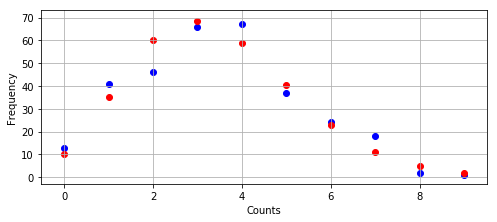

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,3.2))

ax.scatter(count_act, freq_act, color='b', label='Measurements')
ax.scatter(count_act, freq_theo, color='r', label='Poisson')

ax.set_xlabel('Counts')
ax.set_ylabel('Frequency')

ax.grid()

plt.show()

### Compute Optimal m for Poisson Distribution

In [12]:
num_bins = len(count_act)
DOF = num_bins - 2

In [13]:
m=np.linspace(3, 4, 100)
chi_test = compute_chi2(m, count_act, freq_act, num_events)

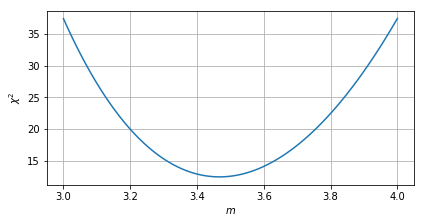

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,3.2))

ax.plot(m, chi_test)
ax.set_xlabel('$m$')
ax.set_ylabel('$\chi^2$')

ax.grid()

fig.tight_layout()
plt.savefig("plots/part1_chi2_ind3count.png", bbox_inches='tight', dpi=1000)
plt.show()

Print the value of $m$ that corresponds to the smallest $\chi^2$ value.

In [15]:
i = np.argmin(chi_test)
m[i]

3.4646464646464645

Print the minimum value of $\chi^2$ and the $p$ value.

In [16]:
print('Minimum chi2 value is '+str(min(chi_test)))
print('p value is '+str(1 - sp.stats.chi2.cdf(min(chi_test), DOF)))

Minimum chi2 value is 12.510103933772273
p value is 0.1298540417288805


### Compute Optimal Parameters for Gaussian Distribution

In [17]:
p0  = (np.mean(count_act), np.std(count_act), np.max(freq_theo))
popt, pcov = curve_fit(norm, count_act, freq_act, p0=p0)

Plots Poisson with Ideal M

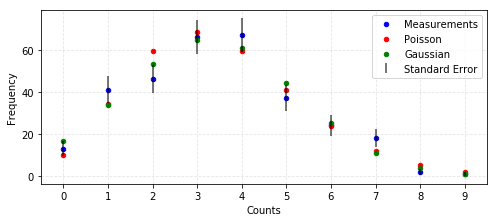

In [18]:
freq_theo = num_events*poisson(count_act, m[i]) 
freq_act_err = np.sqrt(freq_act)

fig, ax = plt.subplots(1,1, figsize=(8,3.2))

ax.scatter(count_act, freq_act, color='b', label='Measurements', s=20)
ax.scatter(count_act, freq_theo, color='r', label='Poisson', s=20)
ax.scatter(count_act, norm(count_act, popt[0], popt[1], popt[2]), label='Gaussian', color='g', s=20)
ax.errorbar(count_act, freq_act, yerr=freq_act_err, linestyle='', color='k', alpha=0.7, label='Standard Error', elinewidth=1.5)

ax.set_xlabel('Counts')
ax.set_ylabel('Frequency')

plt.xticks(np.arange(min(count_act), max(count_act)+1, 1.0))
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.1)
ax.legend()

plt.savefig("plots/appendix_ind_3count.png", bbox_inches='tight', dpi=300)
plt.show()

In [19]:
chi_test = compute_chi2_gaus(freq_act, norm(count_act, popt[0], popt[1], popt[2]))
print('Minimum chi2 value is '+str(chi_test))
print('p value is '+str(1 - sp.stats.chi2.cdf(chi_test, DOF)))

Minimum chi2 value is 10.571039634299945
p value is 0.22720865725261097


## 50 Counts Bottom Scintillator 1.23V

Open DataFrame:

In [20]:
df = pd.read_csv('plateau_data/solo_50.txt', skiprows=12, names=['counts'])
data = df['counts'][0:305].astype(int)
num_events = len(data)

Get Data:

In [21]:
freq_act, _ = np.histogram(data, max(data)-min(data)+1)
count_act = np.arange(min(data), max(data)+1, 1)
freq_theo = num_events*poisson(count_act, np.mean(data)) 

Plotting:

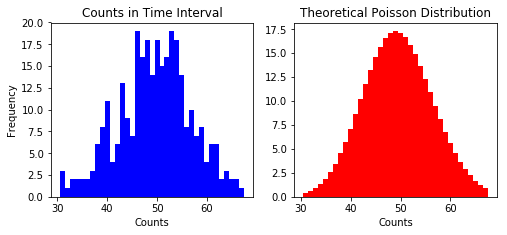

In [22]:
fig, ax = plt.subplots(1,2, figsize=(8,3.2))


ax[0].bar(count_act, freq_act, width=1, color='b')
ax[1].bar(count_act, freq_theo, width=1, color='r')

ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Counts')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Counts in Time Interval')
ax[1].set_title('Theoretical Poisson Distribution')

plt.show()

### Compute Optimal m for Poisson Distribution

In [23]:
num_bins = len(count_act)
DOF = num_bins - 2

In [24]:
m=np.linspace(45, 55, 100)
chi_test = compute_chi2(m, count_act, freq_act, num_events)

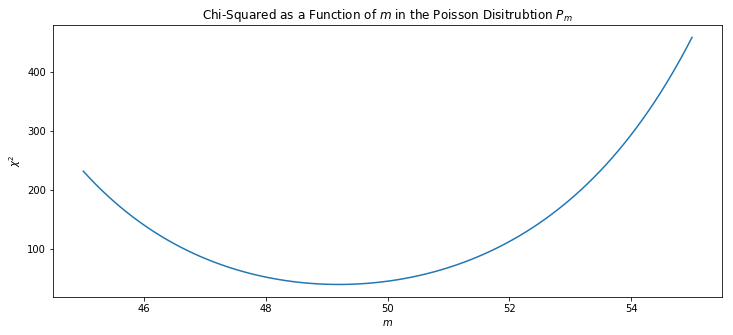

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

ax.plot(m, chi_test)
ax.set_title('Chi-Squared as a Function of $m$ in the Poisson Disitrubtion $P_m$')
ax.set_xlabel('$m$')
ax.set_ylabel('$\chi^2$')

plt.show()

Print the value of $m$ that corresponds to the smallest $\chi^2$ value.

In [26]:
i = np.argmin(chi_test)
m[i]

49.24242424242424

Print the minimum value of $\chi^2$.

In [27]:
print('Minimum chi2 value is '+str(min(chi_test)))
print('p value is '+str(1 - sp.stats.chi2.cdf(min(chi_test), DOF)))

Minimum chi2 value is 40.31720588723792
p value is 0.24674877850593557


### Compute Optimal Parameters for Gaussian Distribution

In [28]:
p0  = (np.mean(count_act), np.std(count_act), np.max(freq_theo))
popt, pcov = curve_fit(norm, count_act, freq_act, p0=p0)

Plots Poisson with Ideal M

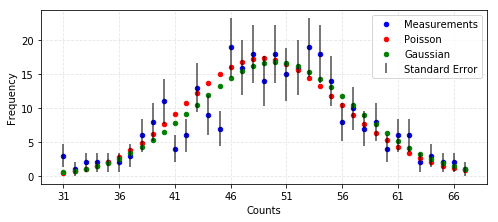

In [29]:
freq_theo = num_events*poisson(count_act, m[i]) 
freq_act_err = np.sqrt(freq_act)

fig, ax = plt.subplots(1,1, figsize=(8,3.2))

ax.scatter(count_act, freq_act, color='b', label='Measurements', s=20)
ax.scatter(count_act, freq_theo, color='r', label='Poisson', s=20)
ax.scatter(count_act, norm(count_act, popt[0], popt[1], popt[2]), label='Gaussian', color='g', s=20)
ax.errorbar(count_act, freq_act, yerr=freq_act_err, linestyle='', color='k', alpha=0.7, label='Standard Error', elinewidth=1.5)

ax.set_xlabel('Counts')
ax.set_ylabel('Frequency')

plt.xticks(np.arange(min(count_act), max(count_act)+1, 5.0))
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.1)
ax.legend()

plt.savefig("plots/appendix_ind_50count.png", bbox_inches='tight', dpi=300)
plt.show()

In [30]:
chi_test = compute_chi2_gaus(freq_act, norm(count_act, popt[0], popt[1], popt[2]))
print('Minimum chi2 value is '+str(chi_test))
print('p value is '+str(1 - sp.stats.chi2.cdf(chi_test, DOF)))

Minimum chi2 value is 34.11611041435572
p value is 0.5106071130387947


## 3 Count Interval Both Scintillators Top 1.43V Bot 1.23V

In [31]:
df = pd.read_csv('plateau_data/in_sync_3.txt', skiprows=12, names=['counts'])
data = df['counts'][0:305].astype(int)
data=data[data<10]

num_events = len(data)

In [32]:
freq_act, _ = np.histogram(data, max(data)-min(data)+1)
count_act = np.arange(min(data), max(data)+1, 1)
freq_theo = num_events*poisson(count_act, np.mean(data)) 

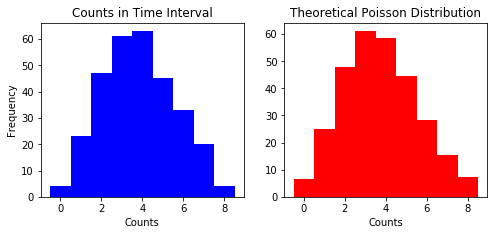

In [33]:
fig, ax = plt.subplots(1,2, figsize=(8,3.2))


ax[0].bar(count_act, freq_act, width=1, color='b')
ax[1].bar(count_act, freq_theo, width=1, color='r')

ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Counts')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Counts in Time Interval')
ax[1].set_title('Theoretical Poisson Distribution')

plt.show()

### Compute Optimal m for Poisson Distribution

In [34]:
num_bins = len(count_act)
DOF = num_bins - 2

In [35]:
m=np.linspace(3, 5, 100)
chi_test = compute_chi2(m, count_act, freq_act, num_events)

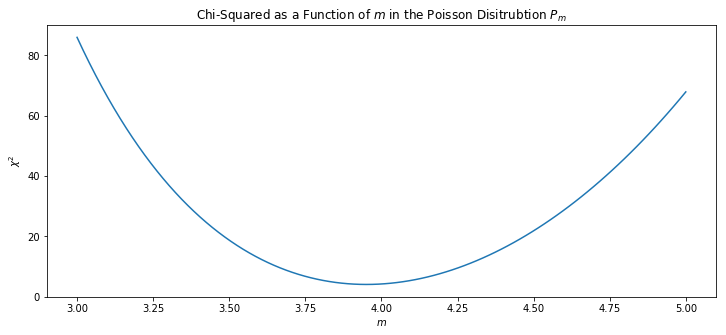

In [36]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

ax.plot(m, chi_test)
ax.set_title('Chi-Squared as a Function of $m$ in the Poisson Disitrubtion $P_m$')
ax.set_xlabel('$m$')
ax.set_ylabel('$\chi^2$')

plt.show()

Print the value of $m$ that corresponds to the smallest $\chi^2$ value.

In [37]:
i = np.argmin(chi_test)
m[i]

3.94949494949495

Print the minimum value of $\chi^2$.

In [38]:
print('Minimum chi2 value is '+str(min(chi_test)))
print('p value is '+str(1 - sp.stats.chi2.cdf(min(chi_test), DOF)))

Minimum chi2 value is 4.087181055662018
p value is 0.7696828988988729


### Compute Optimal Parameters for Gaussian Distribution

In [39]:
p0  = (np.mean(count_act), np.std(count_act), np.max(freq_theo))
popt, pcov = curve_fit(norm, count_act, freq_act, p0=p0)

Plots Poisson with Ideal M

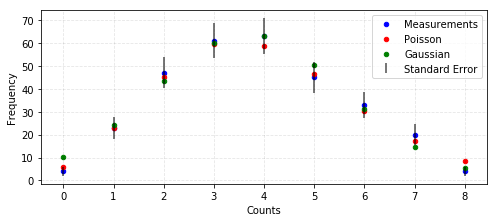

In [40]:
freq_theo = num_events*poisson(count_act, m[i]) 
freq_act_err = np.sqrt(freq_act)

fig, ax = plt.subplots(1,1, figsize=(8,3.2))

ax.scatter(count_act, freq_act, color='b', label='Measurements', s=20)
ax.scatter(count_act, freq_theo, color='r', label='Poisson', s=20)
ax.scatter(count_act, norm(count_act, popt[0], popt[1], popt[2]), label='Gaussian', color='g', s=20)
ax.errorbar(count_act, freq_act, yerr=freq_act_err, linestyle='', color='k', alpha=0.7, label='Standard Error', elinewidth=1.5)

ax.set_xlabel('Counts')
ax.set_ylabel('Frequency')

plt.xticks(np.arange(min(count_act), max(count_act)+1, 1.0))
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.1)
ax.legend()

plt.savefig("plots/appendix_duo_3count.png", bbox_inches='tight', dpi=300)
plt.show()

In [41]:
chi_test = compute_chi2_gaus(freq_act, norm(count_act, popt[0], popt[1], popt[2]))
print('Minimum chi2 value is '+str(chi_test))
print('p value is '+str(1 - sp.stats.chi2.cdf(chi_test, DOF)))

Minimum chi2 value is 7.195338371199645
p value is 0.4088288002003806


## 50 Count Interval Both Scintillators Top 1.43V Bot 1.23V

In [42]:
df = pd.read_csv('plateau_data/in_sync_50.txt', skiprows=12, names=['counts'])
data = df['counts'][0:305].astype(int)
num_events = len(data)

In [43]:
freq_act, _ = np.histogram(data, max(data)-min(data)+1)
count_act = np.arange(min(data), max(data)+1, 1)
freq_theo = num_events*poisson(count_act, np.mean(data)) 

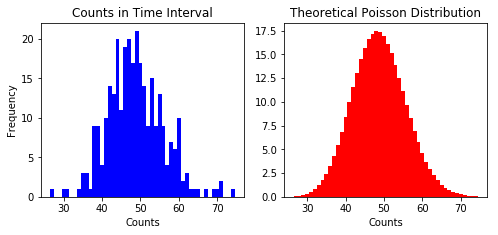

In [44]:
fig, ax = plt.subplots(1,2, figsize=(8,3.2))

ax[0].bar(count_act, freq_act, width=1, color='b')
ax[1].bar(count_act, freq_theo, width=1, color='r')

ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Counts')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Counts in Time Interval')
ax[1].set_title('Theoretical Poisson Distribution')

plt.show()

### Compute Optimal m for Poisson Distribution

In [45]:
num_bins = len(count_act)
DOF = num_bins - 2

In [46]:
m=np.linspace(45, 56, 100)
chi_test = compute_chi2(m, count_act, freq_act, num_events)

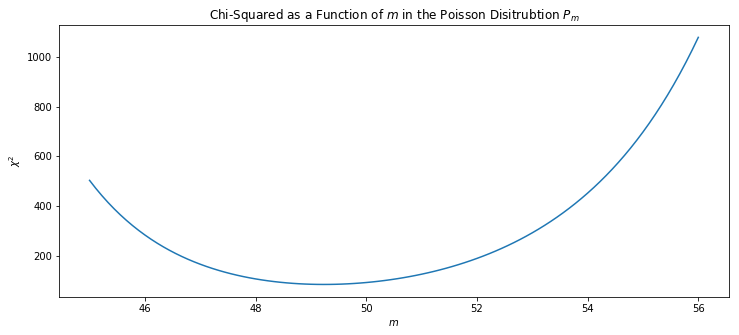

In [47]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

ax.plot(m, chi_test)
ax.set_title('Chi-Squared as a Function of $m$ in the Poisson Disitrubtion $P_m$')
ax.set_xlabel('$m$')
ax.set_ylabel('$\chi^2$')

plt.show()

Print the value of $m$ that corresponds to the smallest $\chi^2$ value.

In [48]:
i = np.argmin(chi_test)
m[i]

49.22222222222222

Print the minimum value of $\chi^2$.

In [49]:
print('Minimum chi2 value is '+str(min(chi_test)))
print('p value is '+str(1 - sp.stats.chi2.cdf(min(chi_test), DOF)))

Minimum chi2 value is 84.20424670300027
p value is 0.0005019520285309831


### Compute Optimal Parameters for Gaussian Distribution

In [50]:
p0  = (np.mean(count_act), np.std(count_act), np.max(freq_theo))
popt, pcov = curve_fit(norm, count_act, freq_act, p0=p0)

Plots Poisson with Ideal M

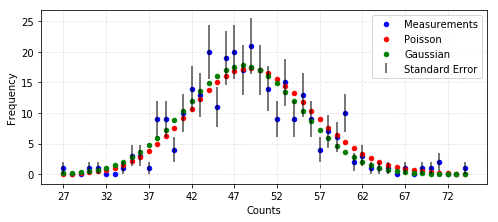

In [51]:
freq_theo = num_events*poisson(count_act, m[i]) 
freq_act_err = np.sqrt(freq_act)

fig, ax = plt.subplots(1,1, figsize=(8,3.2))

ax.scatter(count_act, freq_act, color='b', label='Measurements', s=20)
ax.scatter(count_act, freq_theo, color='r', label='Poisson', s=20)
ax.scatter(count_act, norm(count_act, popt[0], popt[1], popt[2]), label='Gaussian', color='g', s=20)
ax.errorbar(count_act, freq_act, yerr=freq_act_err, linestyle='', color='k', alpha=0.7, label='Standard Error', elinewidth=1.5)

ax.set_xlabel('Counts')
ax.set_ylabel('Frequency')

plt.xticks(np.arange(min(count_act), max(count_act)+1, 5.0))
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.1)
ax.legend()

plt.savefig("plots/appendix_duo_50count.png", bbox_inches='tight', dpi=300)
plt.show()

In [52]:
chi_test = compute_chi2_gaus(freq_act, norm(count_act, popt[0], popt[1], popt[2]))
print('Minimum chi2 value is '+str(chi_test))
print('p value is '+str(1 - sp.stats.chi2.cdf(chi_test, DOF)))

Minimum chi2 value is 233.71373526427925
p value is 0.0


# Conclusion

$\chi^2$ is higher for the scintillators in sync than it is apart. This suggests that cosmic rays are not poisson distributed. This is understandable:

"Poisson Probability Distribution requires events to occur with a constant rate and independtly of the last event."

While the extra noise picked up by 1 scintillator on its own is poisson distribtued (and helps lower the chi-square value) the 2 scintillators on top of eachother (which isolate cosmic events) measure only the cosmic ray data which is inherently non-poisson.

The reason cosmic rays are non-poisson is because events are influenced by previous events. This is obvious by just looking at the counter, the particles tend to come in packets: i.e a particle is more likely to be measured directly after another event. 